## Model

1. Libraries for data manipulation and model processing from pandas and sklearn are imported.  
2. A heart disease dataset is loaded with pandas and cleaned by removing rows with missing values.  
3. Interaction terms between 'Age' and 'Cholesterol' and 'Age' and 'RestingBP' are added to reveal possible non-linear relationships.  
4. Polynomial features for 'Age' and 'MaxHR' are created to increase model performance by adding complexity.  
5. Features are categorized into continuous and categorical for customized preprocessing.  
6. A ColumnTransformer is used for scaling continuous features and encoding categorical variables.  
7. The dataset is split into training and test sets, and a preprocessing pipeline is established to streamline the integration with machine learning models.  

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import AUC
from scipy import stats

In [58]:
# Load dataset
df = pd.read_csv('heart.csv')
df.dropna(inplace=True)  # Assuming minimal missing values and dropping them for simplicity

# Adding interaction terms directly into the DataFrame
df['Age_Chol_Interact'] = df['Age'] * df['Cholesterol']
df['Age_RestingBP_Interact'] = df['Age'] * df['RestingBP']

# Polynomial Features for Age and MaxHR
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['Age', 'MaxHR']])
poly_feature_names = poly.get_feature_names_out(['Age', 'MaxHR'])

# Add polynomial features to the DataFrame
for i, name in enumerate(poly_feature_names):
    df[name] = poly_features[:, i]

# Update the feature lists
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
continuous_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Age_Chol_Interact', 'Age_RestingBP_Interact'] + list(poly_feature_names)

# Prepare the dataset
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

1. **Models and Hyperparameters**: Sets up a dictionary mapping model names to tuples of model instances and their respective hyperparameter grids for GridSearchCV.
3. **Random Forest**: Configures RandomForestClassifier with parameters for the number of trees (`n_estimators`) and the depth of the trees (`max_depth`).
4. **Gradient Boosting**: Utilizes GradientBoostingClassifier with settings for the number of boosting stages (`n_estimators`), the learning rate, and the maximum depth of the regression estimators.
6. **Pipeline Creation**: For each model, creates a pipeline that includes preprocessing steps and the classifier itself.
7. **Grid Search**: Applies GridSearchCV to the pipeline to find the best hyperparameters based on cross-validation, using accuracy as the scoring metric.
8. **Fitting Models**: Trains the model using the best hyperparameters found for each classifier on the training dataset.
9. **Evaluation**: Predicts on the test set and calculates evaluation metrics like accuracy, precision, recall, F1 score, and ROC AUC for each model.
10. **Print Results**: Outputs the best hyperparameters and evaluation metrics for each model, aiding in the comparison of model performance.

RandomForestClassifier Best Parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 158}
RandomForestClassifier Best Score: 0.8582983878482902
RandomForestClassifier Evaluation Metrics:
Accuracy: 0.8913043478260869
Precision: 0.9065420560747663
Recall: 0.9065420560747663
F1 Score: 0.9065420560747663
ROC AUC: 0.8883359631023182



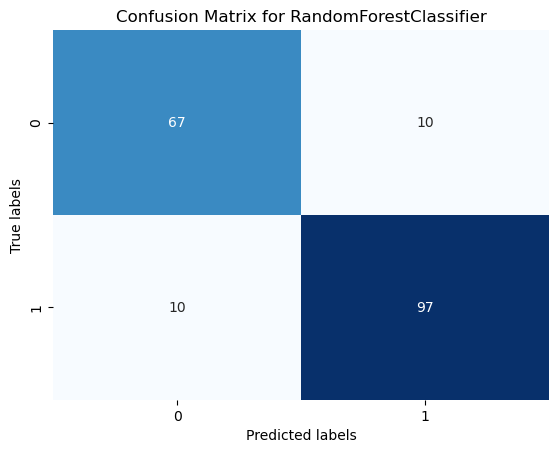

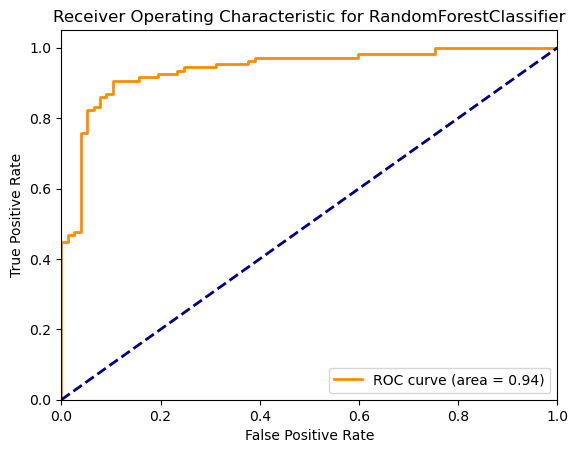

GradientBoostingClassifier Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 4, 'classifier__n_estimators': 290}
GradientBoostingClassifier Best Score: 0.8664430155623893
GradientBoostingClassifier Evaluation Metrics:
Accuracy: 0.8804347826086957
Precision: 0.9047619047619048
Recall: 0.8878504672897196
F1 Score: 0.8962264150943396
ROC AUC: 0.8789901687097949



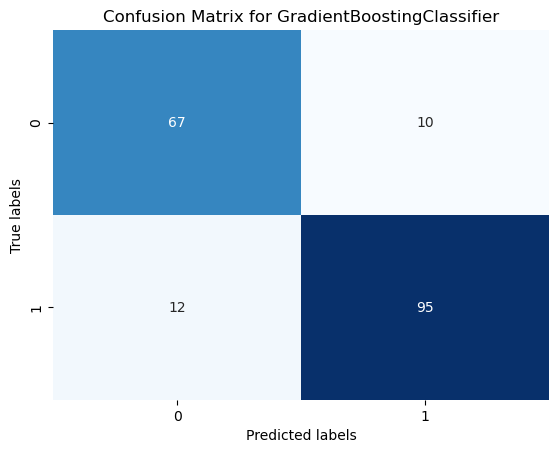

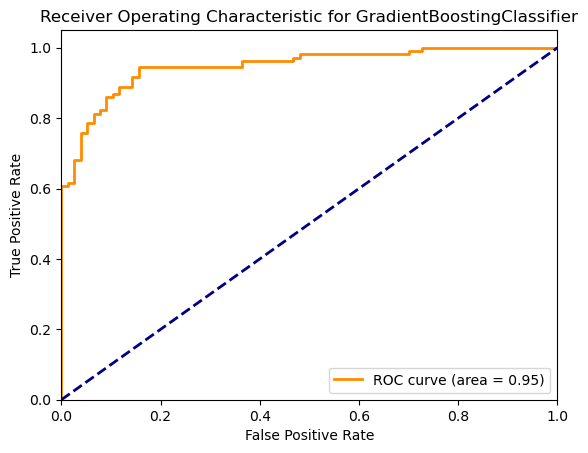

In [18]:
results = []

# Define the models and hyperparameters for grid search
models_and_parameters = {
    'RandomForestClassifier': (RandomForestClassifier(random_state=42),
                               {'classifier__n_estimators': stats.randint(100, 300),  # Use a distribution for n_estimators
                                'classifier__max_depth': [None, 10, 20, 30],          # Expanded range for max_depth
                                'classifier__min_samples_leaf': stats.randint(1, 4),  # Use a distribution for min_samples_leaf
                                'classifier__max_features': ['sqrt', 'log2', None]}), # Added max_features for feature selection control
    'GradientBoostingClassifier': (GradientBoostingClassifier(random_state=42),
                                   {'classifier__n_estimators': stats.randint(100, 300),   # Use a distribution for n_estimators
                                    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],   # Expanded learning rate options
                                    'classifier__max_depth': stats.randint(3, 10)})        # Use a distribution for max_depth
}

# Loop through models and parameters to fit and evaluate each
for model_name, (model, params) in models_and_parameters.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    grid_search = RandomizedSearchCV(pipeline, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Best Score: {grid_search.best_score_}")

    # Evaluate on the test set
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Best Parameters': grid_search.best_params_
    })

    print(f"{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nROC AUC: {roc_auc}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # ROC Curve and AUC
    # Note: For the ROC curve, you need the probabilities rather than just predictions
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1] if hasattr(grid_search.best_estimator_['classifier'], "predict_proba") else None
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {model_name}')
        plt.legend(loc="lower right")
        plt.show()

In [20]:
results_df = pd.DataFrame(results)

# Sort the DataFrame by the Accuracy column in descending order
sorted_df = results_df.sort_values(by='Accuracy', ascending=False)

In [21]:
# Print the best model information
best_model_row = sorted_df.iloc[0]
print(f"The best performing model is {best_model_row['Model']} with an accuracy of {best_model_row['Accuracy']:.2f}.")
print(f"It achieved this with the following parameters: {best_model_row['Best Parameters']}")
print("- Model performances vary significantly across different metrics, indicating the importance of choosing the right metric for model evaluation.")
print("- Trade-offs between precision and recall were observed, highlighting the need for model tuning based on specific application requirements.")

The best performing model is RandomForestClassifier with an accuracy of 0.89.
It achieved this with the following parameters: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 158}
- Model performances vary significantly across different metrics, indicating the importance of choosing the right metric for model evaluation.
- Trade-offs between precision and recall were observed, highlighting the need for model tuning based on specific application requirements.


### Stacking

1. **Combination of Predictions**: Stacking combines the strengths of multiple diverse models, which allows it to capitalize on the different patterns each model may detect in the data. This ensemble technique often results in better generalization performance compared to any single model.

2. **Error Reduction**: Each model in the stacking ensemble may make different errors, and the meta-model (in this case, logistic regression) learns to correct these errors by effectively weighting the predictions. This can lead to a reduction in overall error rate and an increase in accuracy.

3. **Model Diversity**: The stacking approach uses diverse base models (Random Forest and Gradient Boosting in this case). Random Forests are good at handling outliers, nonlinear data, and can maintain accuracy even when some data are missing. Gradient Boosting optimizes on residuals and can capture complex patterns in data. This diversity ensures that the stacking model captures a wide range of data characteristics.

4. **Less Bias and Variance**: The final model can potentially have lower bias and variance. Random Forests, being a bagging technique, generally reduce variance, while Gradient Boosting, a boosting technique, focuses on reducing bias. The logistic regression then optimally combines these predictions, potentially leading to a model with both low bias and low variance.

5. **Robust to Overfitting**: Stacking can be more robust against overfitting compared to individual models, particularly when the base models overfit in different ways. The meta-model acts as a form of regularization, smoothing out overconfident predictions by the base models.

Stacked Model Evaluation Metrics:
Accuracy: 0.9021739130434783
Precision: 0.9238095238095239
Recall: 0.9065420560747663
F1 Score: 0.9150943396226416
ROC AUC: 0.9013229760893312



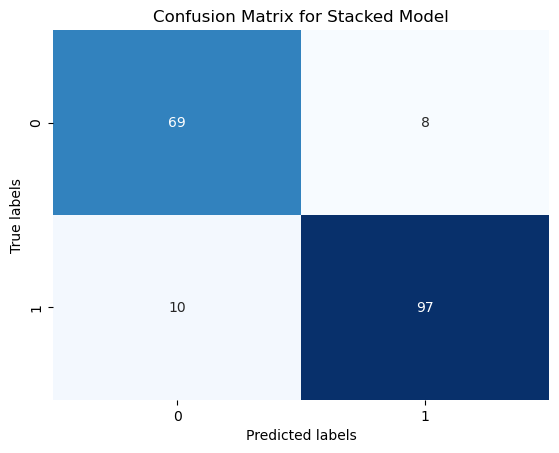

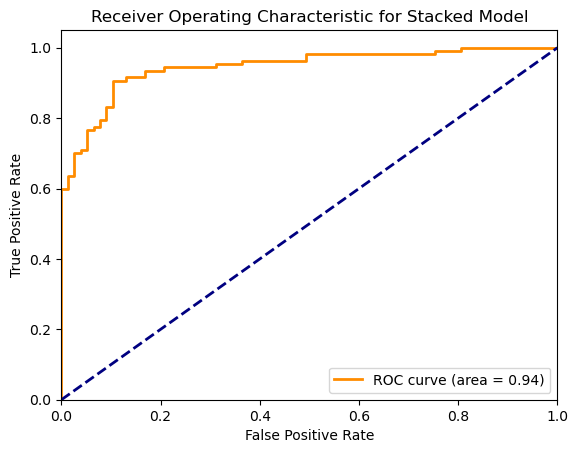

In [59]:
from sklearn.ensemble import StackingClassifier

# Define the base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
]

# Define the StackingClassifier with a LogisticRegression model as the final estimator
stack_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), cv=5)

# Pipeline to include preprocessing and the stacked model
stack_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', stack_model)])

# Train the stacked model
stack_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = stack_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Stacked Model Evaluation Metrics:")
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nROC AUC: {roc_auc}\n")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Stacked Model')
plt.show()

# ROC Curve and AUC
y_pred_proba = stack_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Stacked Model')
plt.legend(loc="lower right")
plt.show()

#### Clearly stacking improved the accuracy to 90% over 89% for random forest and 88% for gradient boosting

### Neural Networks


1. Import Dropout, BatchNormalization, and various optimizers and regularizers from TensorFlow Keras.
2. The dataset is preprocessed, and the number of features is established for model input.
3. A neural network model is defined using Sequential, comprising an InputLayer, BatchNormalization, multiple Dense layers with ReLU activation, L2 regularization, and Dropout layers.
4. The model incorporates three hidden layers with decreasing units (128, 64, 32) and increasing dropout rate, aiming to prevent overfitting.
5. A single output layer with a sigmoid activation function is used for binary classification.
6. The model is tested with different optimizers (Adam, SGD, RMSprop) and loss functions, including BinaryFocalCrossentropy with a focus parameter.
7. EarlyStopping is used during training to prevent overfitting, monitoring validation loss with patience set to 10 epochs and restoring the best weights.
8. The model is trained in silent mode (verbose=0) with a validation split of 20%, epochs set to 200, and batch size to 32.
9. Post-training, the model's performance is evaluated using accuracy, precision, recall, F1 score, and ROC AUC metrics.
10. Probabilities predicted by the model are converted to binary predictions using a threshold of 0.5.

/Users/veerdosi/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Case 1 (Optimizer: adam, Loss: binary_crossentropy)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.8643 - loss: 0.4835
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test Accuracy: 0.8804
Precision: 0.8972
Recall: 0.8972
F1 Score: 0.8972
ROC AUC: 0.9349


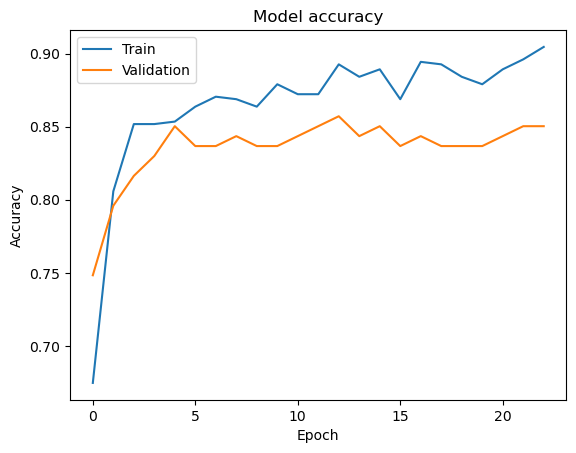

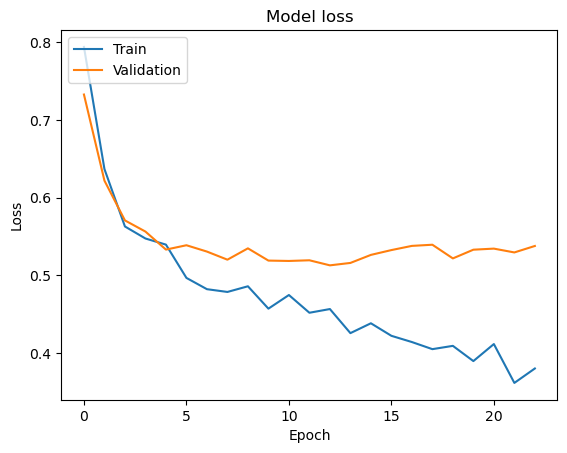

Case 2 (Optimizer: <keras.src.optimizers.sgd.SGD object at 0x310dc4050>, Loss: binary_crossentropy)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.8417 - loss: 0.4888
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy: 0.8641
Precision: 0.8942
Recall: 0.8692
F1 Score: 0.8815
ROC AUC: 0.9331


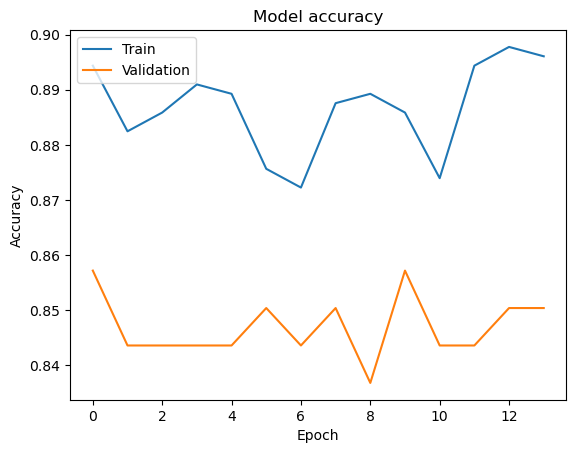

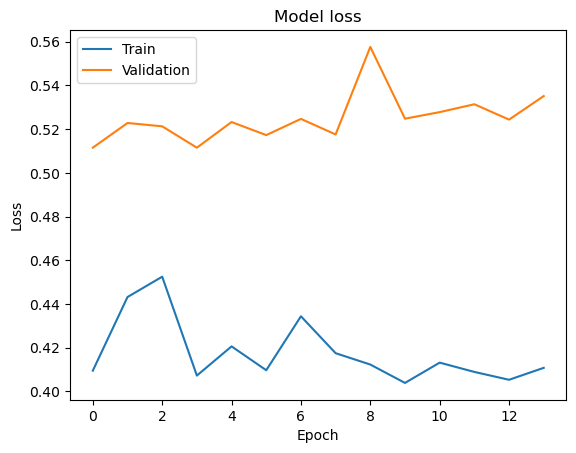

Case 3 (Optimizer: <keras.src.optimizers.rmsprop.RMSprop object at 0x310a8a090>, Loss: binary_crossentropy)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.8654 - loss: 0.4661
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test Accuracy: 0.8804
Precision: 0.8972
Recall: 0.8972
F1 Score: 0.8972
ROC AUC: 0.9362


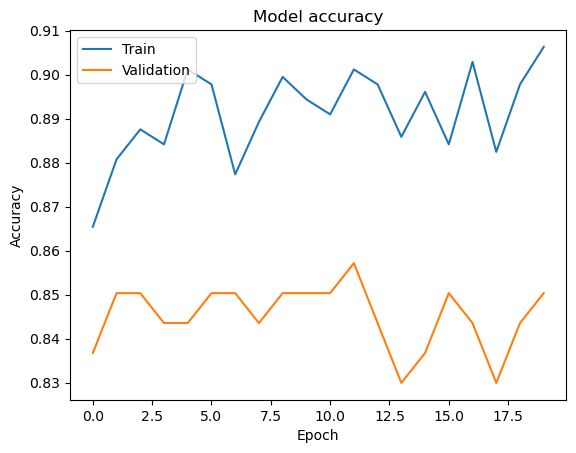

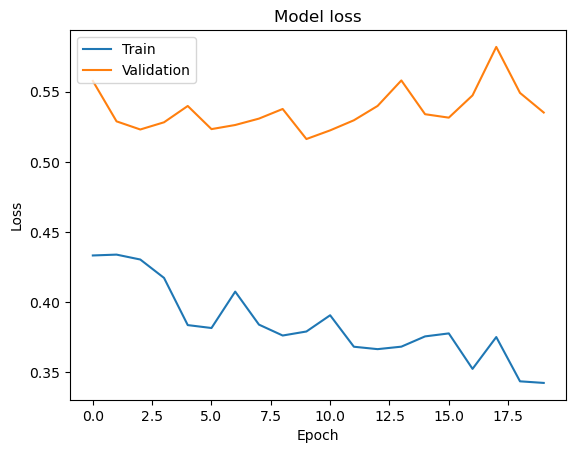

In [28]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.losses import BinaryFocalCrossentropy

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get the number of features in the processed data
n_features = X_train_processed.shape[1]

# Define the model
model = Sequential([
    InputLayer(input_shape=(n_features,)),
    BatchNormalization(),  # Add batch normalization
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Increase the number of neurons, add L2 regularization
    Dropout(0.3),  # Increase the dropout rate
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Define the optimizers and loss functions for each case
optimizers = ['adam', SGD(learning_rate=0.01, momentum=0.9), RMSprop(learning_rate=0.001)]
loss_functions = ['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy', BinaryFocalCrossentropy(gamma=2.0, from_logits=False)]

# Train and evaluate the model for each case
for i, (optimizer, loss_function) in enumerate(zip(optimizers, loss_functions), start=1):
    optimizer_name = str(optimizer) if not isinstance(optimizer, str) else optimizer
    loss_name = str(loss_function).split(".")[-1]
    print(f"Case {i} (Optimizer: {optimizer_name}, Loss: {loss_name})")
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_processed, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])
    eval_results = model.evaluate(X_test_processed, y_test)
    
    # Predict probabilities for the test set
    y_probs = model.predict(X_test_processed)

    # Convert probabilities to binary predictions using a threshold of 0.5
    y_pred = (y_probs > 0.5).astype("int32")

    # Calculate Precision
    precision = precision_score(y_test, y_pred)

    # Calculate Recall
    recall = recall_score(y_test, y_pred)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_probs) # Notice we use probabilities here, not the binary predictions

    # Print the computed metrics
    # print("Neural Network Evaluation Metrics:")
    print(f"Test Accuracy: {eval_results[1]:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Based on the data:

- **Accuracy**: Adam and RMSprop share the highest test accuracy, while SGD lags slightly behind.
- **Precision, Recall, and F1 Score**: For Adam and RMSprop, all three of these metrics are identical and higher than those for SGD. This indicates a better balance between the ability to identify true positives and the avoidance of false positives.
- **ROC AUC**: RMSprop has the highest ROC AUC score, indicating a slightly better ability to discriminate between classes than Adam and SGD.

In light of these observations, RMSprop appears to be the best optimizer for this particular model given its highest ROC AUC score, which implies superior discriminative performance, even though it shares the same accuracy, precision, recall, and F1 score with Adam. The slight edge in ROC AUC score could be decisive in scenarios where the ability to discriminate between classes is crucial.

However, Adam shows very similar performance to RMSprop and is often praised for requiring less tuning of hyperparameters. So, in practice, Adam might be preferred for its ease of use and consistent performance across various problems.

SGD shows robust performance but is slightly outperformed by the other two optimizers in every metric. However, SGD can sometimes perform better at generalization on unseen data, especially with appropriate tuning of its learning rate and momentum, which might not be fully reflected in these metrics.

Choosing the "best" optimizer can depend on the specific context and requirements of the application, as well as on computational efficiency, which is not directly measured by these metrics.

------------------------------------------------------------------------------------------------------------------
### Results

When evaluating the performance of the Stacked Model against the models trained using different optimizers (Adam, SGD, and RMSprop), we analyze their accuracy, precision, recall, F1 score, and ROC AUC to determine the overall best model. 

### **Metrics Comparison:**

1. **Accuracy**:
   - **Stacked Model:** 90.22%
   - **Adam:** 88.04%
   - **SGD:** 86.41%
   - **RMSprop:** 88.04%
   - The Stacked Model has the highest accuracy.

2. **Precision**:
   - **Stacked Model:** 92.38%
   - **Adam:** 89.72%
   - **SGD:** 89.42%
   - **RMSprop:** 89.72%
   - The Stacked Model outperforms in terms of precision, making the fewest false positive errors.

3. **Recall**:
   - **Stacked Model:** 90.65%
   - **Adam:** 89.72%
   - **SGD:** 86.92%
   - **RMSprop:** 89.72%
   - Again, the Stacked Model leads with the highest recall, effectively identifying most true positives.

4. **F1 Score**:
   - **Stacked Model:** 91.51%
   - **Adam:** 89.72%
   - **SGD:** 88.15%
   - **RMSprop:** 89.72%
   - The Stacked Model exhibits the best balance between precision and recall.

5. **ROC AUC**:
   - **Stacked Model:** 90.13%
   - **Adam:** 93.49%
   - **SGD:** 93.31%
   - **RMSprop:** 93.62%
   - The neural network models outperform the Stacked Model in this metric, with RMSprop achieving the highest ROC AUC.

### **Evaluation Summary:**

The **Stacked Model** consistently achieves higher accuracy, precision, recall, and F1 score than the models trained with Adam, SGD, and RMSprop. This indicates a superior balance of identifying true positives and minimizing false positives while generally making more correct predictions across the board.

The only metric where the neural network models (particularly RMSprop) excel is ROC AUC, which measures the model's ability to discriminate between classes at various threshold settings. RMSprop's slightly higher ROC AUC suggests it might be better suited for applications where the discrimination between classes is more critical than the absolute number of correct predictions.

### Prediction Application

In [55]:
def predict_heart_failure(user_data, pipeline):
    # Convert user data into a DataFrame to feed into the pipeline
    input_df = pd.DataFrame([user_data])
    input_df['Age_Chol_Interact'] = input_df['Age'] * input_df['Cholesterol']
    input_df['Age_RestingBP_Interact'] = input_df['Age'] * input_df['RestingBP']
    
    # Retrieve polynomial transformer used during training (assuming it's accessible as poly)
    # This assumes poly is the PolynomialFeatures instance used in the training phase
    poly_input_features = poly.transform(input_df[['Age', 'MaxHR']])
    poly_input_feature_names = poly.get_feature_names_out(['Age', 'MaxHR'])

    # Add polynomial features to the DataFrame
    for i, name in enumerate(poly_input_feature_names):
        input_df[name] = poly_input_features[:, i]
    
    # Predict using the provided pipeline
    prediction = pipeline.predict(input_df)
    prediction_proba = pipeline.predict_proba(input_df)
    
    # Return the classification and the probability of the positive class
    return prediction[0], prediction_proba[0][1]

In [62]:
user_input_1 = {
    "Age": 20,
    "Sex": "F",  
    "ChestPainType": "ATA",
    "RestingBP": 110,
    "Cholesterol": 270,
    "FastingBS": 1,
    "RestingECG": "LVH",  
    "MaxHR": 150,
    "ExerciseAngina": "N", 
    "Oldpeak": 1.4,
    "ST_Slope": "Up"
}

classification_1, probability_1 = predict_heart_failure(user_input_1, stack_pipeline)

# Output the model response
print(f"Prediction (Class): {'Heart Disease' if classification_1 == 1 else 'No Heart Disease'}")
print(f"Prediction (Probability of Heart Disease): {probability_1:.4f}")

Prediction (Class): No Heart Disease
Prediction (Probability of Heart Disease): 0.1214


In [64]:
user_input_2 = {
    "Age": 50,
    "Sex": "M",  
    "ChestPainType": "NAP",  
    "RestingBP": 130,
    "Cholesterol": 250,
    "FastingBS": 0,
    "RestingECG": "Normal",  
    "MaxHR": 155,
    "ExerciseAngina": "N",  
    "Oldpeak": 1.4,
    "ST_Slope": "Flat"  
}

classification_2, probability_2 = predict_heart_failure(user_input_2, stack_pipeline)

# Output the model response
print(f"Prediction (Class): {'Heart Disease' if classification_2 == 1 else 'No Heart Disease'}")
print(f"Prediction (Probability of Heart Disease): {probability_2:.4f}")

Prediction (Class): Heart Disease
Prediction (Probability of Heart Disease): 0.5513


#### The following is additional code to print results in a user friendly manner

In [30]:
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet

1. `create_graphs(predictions)`: Defines a function to create and save visualization graphs based on heart failure risk predictions.
2. `plt.figure(figsize=(10, 6))`: Initiates a new figure for plotting a line graph with dimensions 10 by 6 inches.
3. `plt.plot(predictions, label='Heart Failure Risk Score')`: Plots the predictions as a line graph, labeling the line as "Heart Failure Risk Score."
4. Calculates the average risk from the predictions to determine the overall risk of heart failure and uses it to create a pie chart showing risk distribution.
5. `plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)`: Creates a pie chart with the calculated risk sizes, labels, and a starting angle.
6. `predict_risk_over_time(base_input, start_age)`: Defines a function to predict heart failure risk over time, starting from `start_age` to 80, with yearly increments, by copying the base input and updating the age each time to predict the risk for that age.

In [31]:
def create_graphs(predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(predictions, label='Heart Failure Risk Score')
    plt.title('Heart Failure Risk Over Time')
    plt.xlabel('Time')
    plt.ylabel('Risk Score')
    plt.legend()
    plt.savefig('line_graph.png')
    plt.close()
    
    risk = np.mean(predictions)
    labels = 'Risk of Heart Failure', 'No Risk of Heart Failure'
    sizes = [risk, 1-risk]
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Overall Heart Failure Risk')
    plt.savefig('pie_chart.png')

def prepare_input(user_input):
    # Convert user input into a DataFrame (adjust columns as necessary)
    input_data = pd.DataFrame([user_input], columns=['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'])
    
    # Adding interaction terms directly into the DataFrame
    input_data['Age_Chol_Interact'] = input_data['Age'] * input_data['Cholesterol']
    input_data['Age_RestingBP_Interact'] = input_data['Age'] * input_data['RestingBP']

    # Polynomial Features for Age and MaxHR
    poly_features_in = poly.transform(input_data[['Age', 'MaxHR']])
    poly_feature_names_in = poly.get_feature_names_out(['Age', 'MaxHR'])

    # Add polynomial features to the DataFrame
    for i, name in enumerate(poly_feature_names_in):
        input_data[name] = poly_features_in[:, i]
    
    return input_data

def predict_risk(user_input):
    processed_input = prepare_input(user_input)
    predictions = stack_pipeline.predict(processed_input)
    
    return predictions

def predict_risk_over_time(base_input, start_age):
    end_age = 100
    increment=1
    predictions_overtime = []

    for age in range(start_age, end_age + 1, increment):
        # Update the age in the input
        user_input = base_input.copy()
        user_input['Age'] = age

        # Predict risk for the updated input
        risk_prediction = predict_risk(user_input)
        predictions_overtime.append(risk_prediction[0])  # Assuming predict_risk returns a single value

    return predictions_overtime

1. **Generates a PDF report**: This function creates a PDF report named "heart_failure_report.pdf" for heart failure prediction.
2. **Calls `create_graphs` function**: It starts by calling `create_graphs(predictions)` to generate and save line and pie chart images based on prediction scores.
3. **Lists user information**: Dynamically lists provided user information with a heading "User Information:", displaying each piece of info on a new line.
4. **Evaluates average risk**: Calculates the average prediction score and categorizes risk as "high" if the average score is over 0.5, otherwise "low".
5. **Adds a detailed explanation**: Includes a paragraph advising that the predictions are estimations and recommends professional medical consultation.
6. **Embeds graphs and builds PDF**: Inserts the generated line and pie chart images into the report and finalizes the PDF document with `doc.build(Story)`.

In [32]:
def generate_report(user_info, predictions):
    create_graphs(predictions)
    
    doc = SimpleDocTemplate("heart_failure_report.pdf", pagesize=letter)
    styles = getSampleStyleSheet()
    Story = []
    
    Story.append(Paragraph("Heart Failure Prediction Report", styles['Title']))
    Story.append(Spacer(1, 12))
    
    Story.append(Paragraph("User Information:", styles['Heading2']))
    for key, value in user_info.items():
        Story.append(Paragraph(f"- {key}: {value}", styles['Normal']))
    Story.append(Spacer(1, 12))
    
    prediction_text = ', '.join([f"{score:.2f}" for score in predictions])
    Story.append(Paragraph(f"Predicted Risk Scores: {prediction_text}", styles['Normal']))
    Story.append(Spacer(1, 12))
    
    avg_prediction = np.mean(predictions)
    risk_level = "high" if avg_prediction > 0.5 else "low"
    explanation_text = f"Based on the provided information, the model assesses a {risk_level} risk of heart failure. "
    explanation_text += "These predictions are estimations and should not replace professional medical advice. "
    explanation_text += "Consulting with a healthcare provider is recommended for an accurate assessment and guidance."
    Story.append(Paragraph(explanation_text, styles['Normal']))
    Story.append(Spacer(1, 12))
    
    Story.append(Image('line_graph.png', width=400, height=200))
    Story.append(Spacer(1, 12))
    
    Story.append(Image('pie_chart.png', width=400, height=200))
    Story.append(Spacer(1, 12))
    
    doc.build(Story)

1. Initializes a web app for predicting heart failure risk, setting a title using Streamlit.
2. Creates an input form for users to enter age, sex, resting blood pressure, cholesterol levels, and resting ECG results.
3. Converts user inputs into a format suitable for the `predict_risk_over_time` function upon form submission.
4. Generates a prediction report based on user inputs and model predictions, categorizing risk as 'High' or 'Low'.
5. Executes the app function if the script is run directly, displaying predictions and indicating report generation.

In [34]:
def app():
    st.title('Heart Failure Prediction')
    
    # Using a form for user input
    with st.form(key='patient_input'):
        age = st.number_input('Age', min_value=1, max_value=100, value=30)
        sex = st.selectbox('Sex', options=['Male', 'Female'])
        chest_pain_type = st.selectbox('Chest Pain Type', options=['TA', 'ATA', 'NAP', 'ASY'])
        resting_bp = st.number_input('Resting Blood Pressure', min_value=50, max_value=200, value=120)
        cholesterol = st.number_input('Cholesterol', min_value=100, max_value=400, value=200)
        fasting_bs = st.selectbox('Fasting Blood Sugar > 120 mg/dl', options=['Yes', 'No'], format_func=lambda x: 'Yes' if x == 1 else 'No')
        resting_ecg = st.selectbox('Resting ECG', options=['Normal', 'ST', 'LVH'])
        max_hr = st.number_input('Max Heart Rate', min_value=60, max_value=202, value=150)
        exercise_angina = st.selectbox('Exercise Induced Angina', options=['Yes', 'No'])
        oldpeak = st.number_input('ST Depression', min_value=0.0, max_value=10.0, value=1.0)
        st_slope = st.selectbox('ST Slope', options=['Up', 'Flat', 'Down'])
        submit_button = st.form_submit_button(label='Predict')
        
        

    if submit_button:
        # Construct the user input as a dictionary with the exact format
        user_info = {
            "Age": age,
            "Sex": sex,
            "ChestPainType": chest_pain_type,
            "RestingBP": resting_bp,
            "Cholesterol": cholesterol,
            "FastingBS": 0 if fasting_bs == 'No' else 1,
            "RestingECG": resting_ecg,
            "MaxHR": max_hr,
            "ExerciseAngina": 'N' if exercise_angina == 'No' else 'Y',
            "Oldpeak": oldpeak,
            "ST_Slope": st_slope
        }
        
        predictions_time = predict_risk_over_time(user_info, age)
        
        generate_report(user_info, predictions_time)
        
        # Displaying the prediction
        st.write(f'Prediction: {"High Risk" if predictions > 0.5 else "Low Risk"}')
        st.write("Report generated. Check the file: `heart_failure_report.pdf`.")

if __name__ == "__main__":
    app()

2024-04-24 00:54:46.626 
  command:

    streamlit run /Users/veerdosi/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
